### Importing required libraries.

The data is collected from yahoo finance on a daily basis which can be altered depending on the requirement . 

In [1]:
#Installing Yahoo Finance
#!pip install yfinance
#!pip install pandas_datareader
#!pip install scikeras
#!pip install imbalanced-learn
#!pip install xgboost

In [1]:
import pandas as pd
import talib as ta
import time, datetime
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import os
import yfinance as yf
import pandas_datareader.data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import SGD
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from itertools import product
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import  make_scorer, f1_score

2022-12-02 15:57:08.567357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Importing Data from Yahoo Finance.

In [16]:
#Collecting desired ticker from user
ticker = input("Please enter your desired ticker")
start_time = datetime.datetime(1980,1,1)
end_time = datetime.datetime.now().date()

Please enter your desired ticker ^AXJO


In [103]:
def get_data(ticker):
    #Importing the data from yahoo finance using Pandas Data Reader
    df = pdr.get_data_yahoo(ticker, start=start_time, end=end_time, interval='d')         
    return df

In [4]:
def compute_ema(df):
    # Creating EMA 50 and EMA100 columns in the data frame
    #Setting adjust to False to specify that recursive calculation mode is required.
    df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()

    return df


In [5]:
def computeMACD(df, n_fast, n_slow, n_smooth):
    #Calculating MACD 
    data = df['Close']
    #Calculating Fast EMA and SLOW EMA to calculate MACD indicator.
    fastEMA = data.ewm(span=n_fast, min_periods=n_slow).mean()
    slowEMA = data.ewm(span=n_slow, min_periods=n_slow).mean()
    MACD = pd.Series(fastEMA-slowEMA, name ='MACD')
    df = df.join(MACD)
    return df

In [6]:
def compute_rsi_bb(df):
    # Creating Bolinger Bands with a timeperiod of 20.
    df['upperBB'], df['middleBB'], df['lowerBB'] = ta.BBANDS(df['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    #Creating RSI with a timeperiod of 14
    df['RSI'] = ta.RSI(df['Close'].values, timeperiod=14)
    #Creating a Normalized RSI
    df['nor_RSI'] = ta.RSI(df['Close'].values, timeperiod=14)/100.0
    return df
    

### Creating the feature variables.

In [104]:
def calculated_features(df):
    #Creating Calculated feature columns
    # Creating aboveEMA50 column which indicates 1 if the Close price is over EMA50 and 0 if under EMA50
    df['aboveEMA50'] = np.where(df['Close'] > df['EMA50'], 1, 0)
    # Creating aboveEMA100 column which indicates 1 if the Close price is over EMA100 and 0 if under EMA100
    df['aboveEMA100'] = np.where(df['Close'] > df['EMA100'], 1, 0)
    # Creating aboveupperBB column which indicates 1 if the Close price is over upperBB and 0 if under upperBB
    df['aboveupperBB'] = np.where(df['Close'] > df['upperBB'], 1, 0)
    # Creating belowlowerBB column which indicates 1 if the Close price is under lowerBB and 0 if over lowerBB
    df['belowlowerBB'] = np.where(df['Close'] < df['lowerBB'], 1, 0)
    # Creating oversoldRSI column which indicates 1 if the nor_RSI is under 0.3 and 0 if over 0.3
    df['oversoldRSI'] = np.where(df['nor_RSI'] < 0.30, 1, 0)
    # Creating overboughtRSI column which indicates 1 if the nor_RSI is over 0.7 and 0 if under 0.7
    df['overboughtRSI'] = np.where(df['nor_RSI'] > 0.70, 1, 0)
    return df

In [22]:
# creating a new column in the DF based on the conditions
# Strategy : It is observed that the close price would pull back to the EMA if close to Upper/Lower Bolinger bands. 
def defined_conditions(df):
    # List of conditions
    condition = [(df['aboveEMA50'] == df['aboveEMA100']) & (df['aboveEMA50'] ==1) & (df['MACD']>0.5),
                 (df['aboveEMA50'] != df['aboveEMA100'])]
    # List of values to return
    choice  = [1,0]

    df['Buy/Sell'] = np.select(condition, choice)
    
    return df
#Considering it as a buy if the price is over 50 ema and 100 ema.

#Further analysis is required if the price is over 50 ema and under ema 100 or vice versa.

In [23]:
# creating a new column in the DF based on the conditions

def defined_condition(df):
    # List of conditions
    condition = [(df['aboveupperBB'] == 0) &(df['oversoldRSI']==1),
                 (df['aboveupperBB'] == 1) & (df['overboughtRSI']==1)]
    # List of values to return
    choice  = [1,0]

    df['Buy/Sell'] = np.select(condition, choice)
    
    return df

In [24]:
# creating a new column in the DF based on the conditions

def defined_condition(df):
    # List of conditions
    condition = [(df['aboveEMA50'] == df['aboveEMA100']) & (df['aboveEMA50'] ==1) & (df['belowlowerBB'] == 0),
                 (df['aboveEMA50'] == df['aboveEMA100']) & (df['aboveEMA100'] ==1) & (df['aboveupperBB'] == 1)]
    # List of values to return
    choice  = [1,0]

    df['Buy/Sell'] = np.select(condition, choice)
    
    return df

### Creating DF for Indices.

In [105]:


#Calling the get_data function definition. 
df = get_data(ticker)
df = df.reset_index()
df = df.set_index('Date')
#Calculating EMA 50 and 100
df = compute_ema(df)
# Computing RSI and Bolinger Bands
df = compute_rsi_bb(df)
#Calculating if the signal is to buy or sell.
df = calculated_features(df)
#Computing the MACD indicator
df =computeMACD(df, 12, 26, 9)
# Rules for placing a trade.
df = defined_conditions(df)


In [26]:
#Dropping Null values.
df = df.dropna()
#Converting to numpy
dataMACD = df[['MACD']].to_numpy() 
#Initisting a minmaxscaler() instance
minmaxscaler = MinMaxScaler()
#Normalising MACD
df['norm_MACD'] = minmaxscaler.fit_transform(dataMACD)
df.describe()

,High,Low,Open,Close,Volume,Adj Close,EMA50,EMA100,upperBB,middleBB,...,nor_RSI,aboveEMA50,aboveEMA100,aboveupperBB,belowlowerBB,oversoldRSI,overboughtRSI,MACD,Buy/Sell,norm_MACD
count,7566.000000,7566.000000,7566.000000,7566.000000,7.566000e+03,7566.000000,7566.000000,7566.000000,7566.000000,7566.000000,...,7566.000000,7566.000000,7566.000000,7566.000000,7566.000000,7566.000000,7566.000000,7566.000000,7566.000000,7566.000000
mean,4354.799050,4315.508062,4335.208104,4335.586401,2.921405e+07,4335.586401,4317.739336,4299.754459,4453.699828,4328.450650,...,0.532235,0.638382,0.674729,0.058948,0.052075,0.024451,0.071108,5.096314,0.558948,0.768732
std,1587.118598,1564.109983,1575.702883,1575.845307,1.337313e+08,1575.845307,1569.451254,1563.963239,1619.870505,1573.654970,...,0.116229,0.480501,0.468507,0.235543,0.222193,0.154456,0.257021,49.141466,0.496546,0.067441
min,1502.199951,1502.199951,1502.199951,1502.199951,0.000000e+00,1502.199951,1488.099527,1473.584120,1551.956486,1506.270013,...,0.102320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-555.046227,0.000000,0.000000
25%,3030.350098,3004.900024,3016.900024,3017.274963,0.000000e+00,3017.274963,3017.905004,2998.079045,3090.328387,3014.736246,...,0.451495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.876042,0.000000,0.742695
50%,4461.449951,4417.300049,4442.449951,4443.149902,0.000000e+00,4443.149902,4440.987621,4395.833479,4579.158654,4439.685010,...,0.536543,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.028733,1.000000,0.776874
75%,5612.500122,5553.625000,5584.675171,5587.249878,0.000000e+00,5587.249878,5593.209684,5613.014315,5754.123653,5573.965027,...,0.616903,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,30.476733,1.000000,0.803564
max,7632.799805,7585.899902,7629.000000,7628.899902,1.353735e+09,7628.899902,7439.091097,7368.622413,7735.728944,7527.189990,...,0.843694,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,173.611487,1.000000,1.000000


### Separating Labels and Features from the Data frame and splitting the data

In [27]:
#Droping Null values
df = df.dropna()
#Separating label from df
X = df.drop(columns =['Buy/Sell'])
#Reviewing features Data Frame.
X.head()

,High,Low,Open,Close,Volume,Adj Close,EMA50,EMA100,upperBB,middleBB,...,RSI,nor_RSI,aboveEMA50,aboveEMA100,aboveupperBB,belowlowerBB,oversoldRSI,overboughtRSI,MACD,norm_MACD
Date,,,,,,,,,,,,,,,,,,,,,
1992-12-29,1552.300049,1552.300049,1552.300049,1552.300049,0.0,1552.300049,1488.099527,1473.584120,1583.480784,1506.270013,...,71.687864,0.716879,1,1,0,0,0,1,16.509478,0.784395
1992-12-30,1564.699951,1564.699951,1564.699951,1564.699951,0.0,1564.699951,1491.103465,1475.388394,1588.931723,1511.890009,...,74.471620,0.744716,1,1,0,0,0,1,17.431906,0.785661
1993-01-03,1576.099976,1576.099976,1576.099976,1576.099976,0.0,1576.099976,1494.436661,1477.382682,1594.153979,1518.355005,...,76.736312,0.767363,1,1,0,0,0,1,18.763130,0.787488
1993-01-04,1579.900024,1579.900024,1579.900024,1579.900024,0.0,1579.900024,1497.788166,1479.412729,1597.009817,1525.245007,...,77.454301,0.774543,1,1,0,0,0,1,19.857524,0.788990
1993-01-05,1554.800049,1554.800049,1554.800049,1554.800049,0.0,1554.800049,1500.023926,1480.905547,1592.906120,1530.825012,...,63.511228,0.635112,1,1,0,0,0,0,18.658390,0.787344


In [28]:
y = df['Buy/Sell']
#Reviewing Label.
y.head(5)
# Checking if there is any class imbalances
y.value_counts()

1    4229
0    3337
Name: Buy/Sell, dtype: int64

Enter a file name to save the plot abcd.png


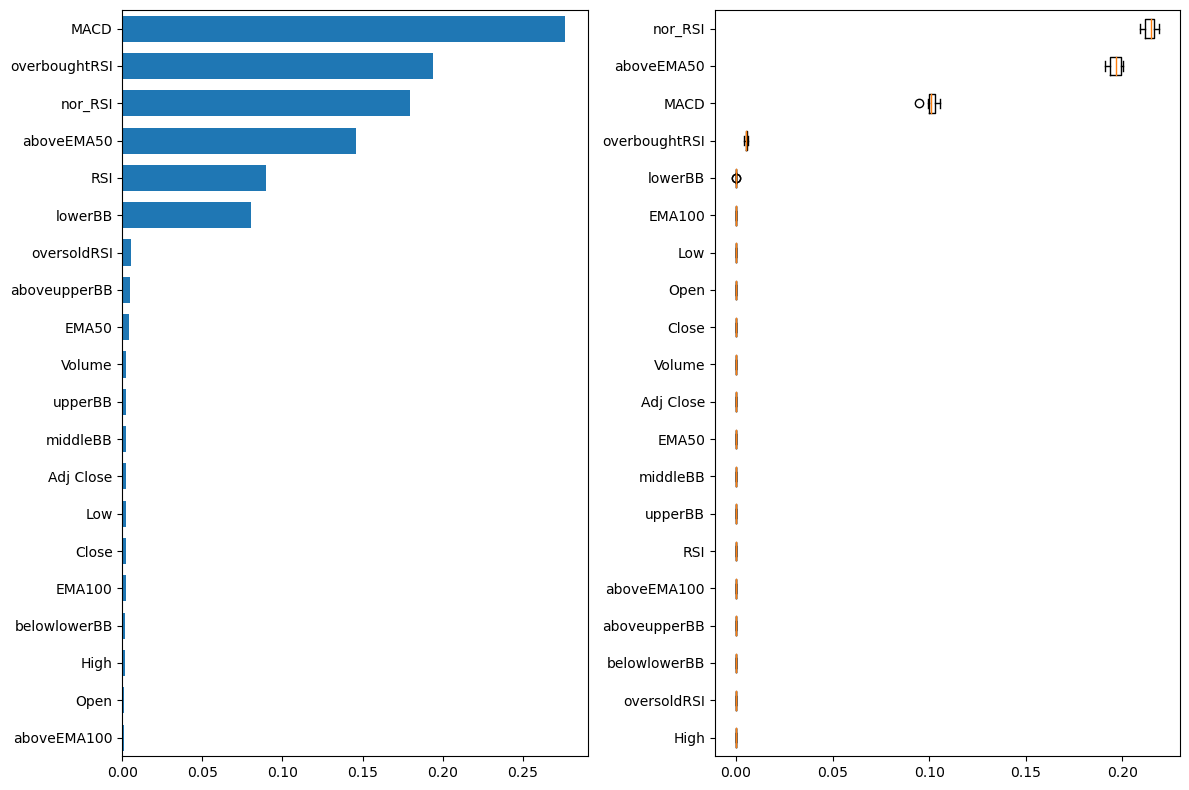

In [108]:
#Initiating a RandomForestClassifier with 100 estimators
clf=RandomForestClassifier(n_estimators=100, random_state=42).fit(X,y)
#Calculating the importance of feature variables
result = permutation_importance(clf, X, y, n_repeats=10,random_state=0)
#Creating a sorted feature importance by mean importance
perm_sorted_idx = result.importances_mean.argsort()
#Sorting the trees based on Gini impurity
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5
# Plotting the importance of each feature variable
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
#ax1.title('Importance of Columns in Feature Data set')
ax1.set_yticklabels(df.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=df.columns[perm_sorted_idx],
)
fig.tight_layout()
plt.savefig(input('Enter a file name to save the plot'))
plt.show()

In [30]:
# Droping Columns oversoldRSI from X.
# For SPY
#X = df.drop(columns =['Buy/Sell','oversoldRSI'])
# FOR ^AJXO
X = df.drop(columns =['Buy/Sell','Volume'])
#Reviewing features Data Frame.
X.head()

,High,Low,Open,Close,Adj Close,EMA50,EMA100,upperBB,middleBB,lowerBB,RSI,nor_RSI,aboveEMA50,aboveEMA100,aboveupperBB,belowlowerBB,oversoldRSI,overboughtRSI,MACD,norm_MACD
Date,,,,,,,,,,,,,,,,,,,,
1992-12-29,1552.300049,1552.300049,1552.300049,1552.300049,1552.300049,1488.099527,1473.584120,1583.480784,1506.270013,1429.059243,71.687864,0.716879,1,1,0,0,0,1,16.509478,0.784395
1992-12-30,1564.699951,1564.699951,1564.699951,1564.699951,1564.699951,1491.103465,1475.388394,1588.931723,1511.890009,1434.848294,74.471620,0.744716,1,1,0,0,0,1,17.431906,0.785661
1993-01-03,1576.099976,1576.099976,1576.099976,1576.099976,1576.099976,1494.436661,1477.382682,1594.153979,1518.355005,1442.556031,76.736312,0.767363,1,1,0,0,0,1,18.763130,0.787488
1993-01-04,1579.900024,1579.900024,1579.900024,1579.900024,1579.900024,1497.788166,1479.412729,1597.009817,1525.245007,1453.480197,77.454301,0.774543,1,1,0,0,0,1,19.857524,0.788990
1993-01-05,1554.800049,1554.800049,1554.800049,1554.800049,1554.800049,1500.023926,1480.905547,1592.906120,1530.825012,1468.743904,63.511228,0.635112,1,1,0,0,0,0,18.658390,0.787344


In [31]:
# Split the data into training and testing datasets
# Assign the function a random_state equal to 1
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state =1,stratify = y)

### Passing the Data to NN to establish a baseline accuracy.

#### Normalising the data using Standard Scaler

In [44]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Scale both the training and testing data from the features dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# encoding class labels as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)

#### Optimising Neural Network using GridSearchCV to optimise Hyperparameters

In [37]:
# Function to generate Deep ANN model 
def class_ann(Optimizer_Trial, Neurons_Trial):
   # Creating the classifier ANN model with imput_dim=20 
    classifier = Sequential()
    classifier.add(Dense(units=Neurons_Trial, input_dim=20, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=Neurons_Trial, kernel_initializer='uniform', activation='relu'))
    classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    classifier.compile(optimizer=Optimizer_Trial, loss='binary_crossentropy', metrics=['accuracy'])
    return classifier



In [39]:
#Creating the list of parameters to try them on data
Parameter_Trials={'batch_size':[10,20],
                      'epochs':[10,20],
                    'Optimizer_Trial':['sgd','adamax'],
                  'Neurons_Trial': [10,15]
                 }
 
# Creating the NN
model_1=KerasClassifier(class_ann, verbose=1)
 
# Creating the Grid search space

grid_search=GridSearchCV(estimator=model_1, param_grid=Parameter_Trials, scoring=make_scorer(f1_score,average='micro'), cv=5)

# Running Grid Search for different paramenters
grid_search.fit(X_train,y_train, verbose=1)

/Users/akhilsai/opt/anaconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if __name__ == "__main__":
2022-12-02 15:01:09.416517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
454/454 [==============================] - 1s 1ms/step - loss: 0.6867 - accuracy: 0.6048
Epoch 2/10
454/454 [==============================] - 1s 2ms/step - loss: 0.6713 - accuracy: 0.6065
Epoch 3/10
454/454 [==============================] - 1s 1ms/step - loss: 0.6705 - accuracy: 0.6065
Epoch 4/10
454/454 [==============================] - 1s 2ms/step - loss: 0.6704 - accuracy: 0.6065
Epoch 5/10
454/454 [==============================] - 1s 2ms/step - loss: 0.6704 - accuracy: 0.6065
Epoch 6/10
454/454 [==============================] - 1s 2ms/step - loss: 0.6704 - accuracy: 0.6065
Epoch 7/10
454/454 [==============================] - 1s 1ms/step - loss: 0.6704 - accuracy: 0.6065
Epoch 8/10
454/454 [==============================] - 1s 1ms/step - loss: 0.6704 - accuracy: 0.6065
Epoch 9/10
454/454 [==============================] - 1s 1ms/step - loss: 0.6704 - accuracy: 0.6065
Epoch 10/10
36/36 [==============================] - 0s 937us/step
Epoch 1/10
454/454 [=============

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f86fc175810>,
             param_grid={'Neurons_Trial': [10, 15],
                         'Optimizer_Trial': ['sgd', 'adamax'],
                         'batch_size': [10, 20], 'epochs': [10, 20]},
             scoring=make_scorer(f1_score, average=micro))

In [40]:
# printing the best parameters
print('The best hyperparameters are : ')
grid_search.best_params_

The best hyperparameters are : 


{'Neurons_Trial': 10,
 'Optimizer_Trial': 'adamax',
 'batch_size': 10,
 'epochs': 20}

In [41]:
def find_best_parameters(X_train, y_train):
    
    # Creating the list of hyperparameters to try
    TrialNumber=0
    batch_size_list=[5, 10, 15, 20]
    epoch_list=[5, 10, 50 ,100]

    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            
            # Creating the classifier ANN model
            classifier = Sequential()
            classifier.add(Dense(units=10, input_dim=20, kernel_initializer='uniform', activation='relu'))
            classifier.add(Dense(units=5, kernel_initializer='uniform', activation='relu'))
            classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
            classifier.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
            
 
            
            nn_model=classifier.fit(X_train,y_train, batch_size=batch_size_trial , epochs=epochs_trial, verbose=0)
            # Fetching the accuracy of the training
            Accuracy = nn_model.history['accuracy'][-1]
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', Accuracy)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber,'batch_size'+str(batch_size_trial)+'-'+'epoch'+str(epochs_trial), Accuracy]],columns=['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
#Calling the defined function and passing X-train and y_train to fit the data
ResultsData=find_best_parameters(X_train, y_train)
print('/n The best parameters are  ',ResultsData.sort_values(by='Accuracy', ascending=False).head(1))

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 0.9080014228820801
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 0.9113500118255615
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 0.9506521224975586
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 0.9714487195014954
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 0.8976030945777893
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 0.6053929924964905
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 0.9529432654380798
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 0.9688050746917725
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 0.906767725944519
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 0.8953119516372681
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 0.9444836378097534
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 0.6053929924964905
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 0.8965456485748291
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 0.6053929924964905
15 Para

In [32]:
def model_demo():
    
    classifier_1 = Sequential()
    classifier_1.add(Dense(units=10, input_dim=20, kernel_initializer='uniform', activation='relu'))
    classifier_1.add(Dense(units=5, kernel_initializer='uniform', activation='relu'))
    classifier_1.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    classifier_1.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])
    return classifier_1

In [87]:
model = model_demo()
#Batch_size =20 for ^AXJO
#Batch size =15 for SPY
model.fit(X_train,y_train, batch_size=20 , epochs=100, verbose=1,shuffle =True)
predicted_y = model.predict(X_test)

Epoch 1/100
284/284 [==============================] - 1s 907us/step - loss: 0.6916 - accuracy: 0.5585
Epoch 2/100
284/284 [==============================] - 0s 1ms/step - loss: 0.6894 - accuracy: 0.5589
Epoch 3/100
284/284 [==============================] - 0s 894us/step - loss: 0.6883 - accuracy: 0.5589
Epoch 4/100
284/284 [==============================] - 0s 811us/step - loss: 0.6876 - accuracy: 0.5589
Epoch 5/100
284/284 [==============================] - 0s 811us/step - loss: 0.6872 - accuracy: 0.5589
Epoch 6/100
284/284 [==============================] - 0s 875us/step - loss: 0.6868 - accuracy: 0.5589
Epoch 7/100
284/284 [==============================] - 0s 854us/step - loss: 0.6865 - accuracy: 0.5589
Epoch 8/100
284/284 [==============================] - 0s 808us/step - loss: 0.6864 - accuracy: 0.5589
Epoch 9/100
284/284 [==============================] - 0s 813us/step - loss: 0.6863 - accuracy: 0.5589
Epoch 10/100
284/284 [==============================] - 0s 838us/step - los

In [88]:
# printing Accuracy score between actual and predicted value

print((accuracy_score(y_test, predicted_y.round())*100))

55.91966173361522


### Creating Ensemble

In [89]:
from sklearn.metrics import log_loss
clf1 = LogisticRegression(random_state=1)
#clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf2 = XGBClassifier()
eclf = VotingClassifier(estimators=[('lr', clf1), ('xgb', clf2), ('gnb', clf3)],voting='hard')


eclf.fit(X_train_scaled, y_train)
 
# predicting the output on the test dataset
pred_final = eclf.predict(X_test_scaled)
 
# printing log loss between actual and predicted value
print("The accuracy of the ensemble model in percentage is",(accuracy_score(y_test, pred_final)*100))

The accuracy of the ensemble model in percentage is 98.62579281183932


In [90]:
for clf, label in zip([clf1, clf2, clf3,eclf], ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X_test_scaled, y_test, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.98 (+/- 0.01) [Logistic Regression]
Accuracy: 1.00 (+/- 0.00) [Random Forest]
Accuracy: 0.94 (+/- 0.01) [Naive Bayes]
Accuracy: 0.98 (+/- 0.01) [Ensemble]


In [91]:
from sklearn.metrics import classification_report
testing_signal_predictions = eclf.predict(X_test_scaled)
 # Evaluate the model's ability to predict the trading signal for the testing data
ensemble_classification_report = classification_report(y_test, testing_signal_predictions)
print(ensemble_classification_report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       834
           1       0.98      1.00      0.99      1058

    accuracy                           0.99      1892
   macro avg       0.99      0.98      0.99      1892
weighted avg       0.99      0.99      0.99      1892



In [165]:
 # Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df["predicted_signal"] = testing_signal_predictions
predictions_df["actual_returns"] = df["Close"].pct_change()
predictions_df["Close"] = df["Close"]
predictions_df["trading_algorithm_returns"] = predictions_df["actual_returns"] * predictions_df["predicted_signal"]
predictions_df.head()

,predicted_signal,actual_returns,Close,trading_algorithm_returns
Date,,,,
2012-07-05,0,-0.000719,4169.200195,-0.000000
2010-04-20,1,0.002177,4925.799805,0.002177
2001-02-27,1,0.007298,3326.500000,0.007298
1994-04-14,0,-0.009863,2027.900024,-0.000000
2005-03-21,1,-0.007641,4233.799805,-0.007641


In [82]:
import hvplot.pandas
plot = (((1 + predictions_df[["actual_returns"]]).cumprod()).hvplot(label="Actual Returns", title = ('Cumulative Product Returns of Actual vs Trading Algorithm Returns'))) *((
    (1 + predictions_df[["trading_algorithm_returns"]]).cumprod()).hvplot(label="Trading Algorithm Returns"))
hvplot.save(plot,input("Please Enter the name with format"))
plot

Please Enter the name with format hvplot.png


:Overlay
   .Curve.Actual_Returns            :Curve   [Date]   (actual_returns)
   .Curve.Trading_Algorithm_Returns :Curve   [Date]   (trading_algorithm_returns)

In [166]:
def plot_prediction(df, ticker):
    df_plot = df.copy()
    df_plot = df.loc[df['Buy/Sell'] == 1,]
#    df_plot['Predicted_y'] = predictions_df.loc[predictions_df['predicted_signal']==1,]
#    df_plot['Close']=predictions_df.loc[predictions_df['predicted_signal']==1,]
    #df_plot_sell = df.loc[df['Buy/Sell'] == 0,]
    close_plot =df_plot.hvplot(x='Date',y='Close', label='Close', alpha=0.2, title = 'Buy Triggers')
    ema50_plot = df_plot.hvplot(x='Date',y= 'EMA50', label='EMA50', alpha=0.2)
    ema100_plot = df_plot.hvplot(x='Date',y='EMA100', label='EMA100', alpha=0.2)
    upperbb_plot =df_plot.hvplot(x='Date',y='upperBB', label='Upper BB', alpha=0.3)
    lowerbb_plot=df_plot.hvplot(x='Date',y='lowerBB', label='Lower BB', alpha=0.3)
    rsi_plot=df_plot.hvplot(x='Date',y='nor_RSI', label='Normalized RSI', alpha=0.2)
    macd_plot =df_plot.hvplot(x='Date',y='MACD', label='MACD', alpha=0.2,title = '')
    scatter_plot = df_plot.hvplot.scatter(x='Date', y='Close', label='Buy', color ='black',marker='^', alpha=0.5)
    a = (close_plot*ema50_plot *ema100_plot*upperbb_plot*lowerbb_plot*rsi_plot*macd_plot*scatter_plot)
    hvplot.save(a,input("Please enter a name with format to save the plot"))
    return a  
##

In [167]:
plot_prediction(df, ticker)

Please enter a name with format to save the plot test34.png


:Overlay
   .Curve.Close          :Curve   [Date]   (Close)
   .Curve.EMA50          :Curve   [Date]   (EMA50)
   .Curve.EMA100         :Curve   [Date]   (EMA100)
   .Curve.Upper_BB       :Curve   [Date]   (upperBB)
   .Curve.Lower_BB       :Curve   [Date]   (lowerBB)
   .Curve.Normalized_RSI :Curve   [Date]   (nor_RSI)
   .Curve.MACD           :Curve   [Date]   (MACD)
   .Scatter.Buy          :Scatter   [Date]   (Close)

In [120]:
portfolio_value = int(input('Please enter the portfolio value'))

Please enter the portfolio value 5000


In [143]:
df_value = predictions_df.copy()
df_value['portfolio_returns'] = df_value["actual_returns"] * df_value["predicted_signal"] * portfolio_value
df_value['algo_returns'] = df_value['portfolio_returns'].cumsum()
df_value['actual_port_returns'] = df_value["actual_returns"] * portfolio_value
df_value['orig_returns'] = df_value['actual_port_returns'].cumsum()

In [163]:
trading_returns_portfolio_plot = df_value.hvplot(x='Date',y = 'algo_returns', hover_cols = 'algo_returns', title = 'Comparision of Actual and Algorithmic Trading Returns', label = 'Algorithmic Portfolio Returns')
original_portfolio_returns_plot = df_value.hvplot(x='Date',y = 'orig_returns', hover_cols = 'orig_returns',label = 'Actual Portfolio Returns')

#hvplot.save((trading_returns_portfolio_plot* original_portfolio_returns_plot),input('Please Enter a name to save chart in PNG format'))
(trading_returns_portfolio_plot* original_portfolio_returns_plot)

:Overlay
   .Curve.Algorithmic_Portfolio_Returns :Curve   [Date]   (algo_returns)
   .Curve.Actual_Portfolio_Returns      :Curve   [Date]   (orig_returns)

In [157]:
print('The actual returns of the portfolio is :',df_value['actual_port_returns'].sum())

The actual returns of the portfolio is : 2651.676468682157


In [158]:
print('Portfolio returns using Algorithmic Trading Bot is : ',df_value['portfolio_returns'].sum())

Portfolio returns using Algorithmic Trading Bot is :  5882.303926401943
